In [135]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

In [136]:
rune_df = pd.read_csv("data/Rune_data.csv")
xp_df = pd.read_csv("data/XP_data.csv")

# Univariate Time Series

Split the data into TRAIN_SPLIT input data points and 1 output point

In [137]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [138]:
TRAIN_SPLIT = 40

In [139]:
tf.random.set_seed(13)

In [140]:
uni_data = rune_df['Chaos_rune']
uni_data.index = rune_df['timestamp']
uni_data.head()

timestamp
1.615926e+09    45
1.616012e+09    45
1.616098e+09    46
1.616186e+09    47
1.616272e+09    47
Name: Chaos_rune, dtype: int64

array([<AxesSubplot:xlabel='timestamp'>], dtype=object)

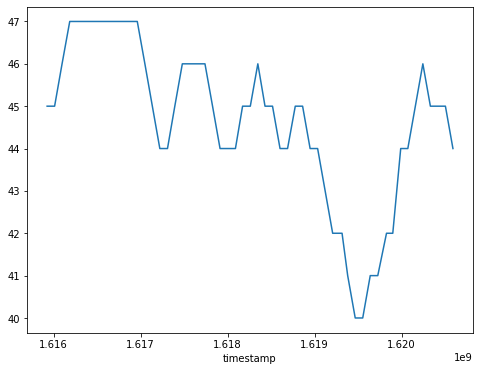

In [141]:
uni_data.plot(subplots=True)

Normalize the data

In [142]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

Data for the univariate model. Model will be given 30 recorded values and learns to predict at the next time step

In [143]:
univariate_past_history = 10
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [144]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[-0.18196863]
 [-0.18196863]
 [ 0.54590589]
 [ 1.27378042]
 [ 1.27378042]
 [ 1.27378042]
 [ 1.27378042]
 [ 1.27378042]
 [ 1.27378042]
 [ 1.27378042]]

 Target to predict
1.2737804191819682


In [145]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [146]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

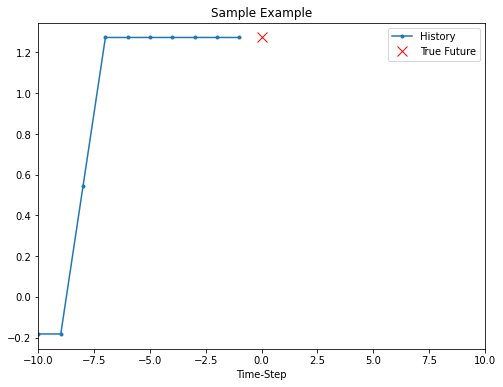

In [147]:
plot = show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
plot.show()

### Baseline prediction

In [148]:
def baseline(history):
  return np.mean(history)

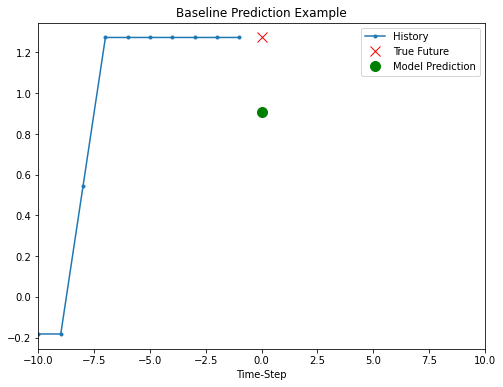

In [149]:
plot = show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')
plot.show()

### Recurrent neural network

In [150]:
BATCH_SIZE = 20
BUFFER_SIZE = 5

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [151]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Sample prediction

In [152]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(5, 1)


Training the model. Each epoch runs for only 200 steps.

In [153]:
EVALUATION_INTERVAL = 500
EPOCHS = 15

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/15
500/500 [==============================] - 4s 4ms/step - loss: 0.5265 - val_loss: 0.7996
Epoch 2/15
500/500 [==============================] - 1s 3ms/step - loss: 0.3811 - val_loss: 0.9005
Epoch 3/15
500/500 [==============================] - 1s 3ms/step - loss: 0.2747 - val_loss: 0.2737
Epoch 4/15
500/500 [==============================] - 1s 3ms/step - loss: 0.2216 - val_loss: 0.3191
Epoch 5/15
500/500 [==============================] - 1s 3ms/step - loss: 0.1919 - val_loss: 0.3935
Epoch 6/15
500/500 [==============================] - 1s 3ms/step - loss: 0.1690 - val_loss: 0.5461
Epoch 7/15
500/500 [==============================] - 1s 3ms/step - loss: 0.1341 - val_loss: 0.7871
Epoch 8/15
500/500 [==============================] - 1s 3ms/step - loss: 0.1062 - val_loss: 0.9748
Epoch 9/15
500/500 [==============================] - 1s 3ms/step - loss: 0.0777 - val_loss: 1.0964
Epoch 10/15
500/500 [==============================] - 1s 3ms/step - loss: 0.0554 - val_loss: 1.1742

Prediction using the simple LSTM model

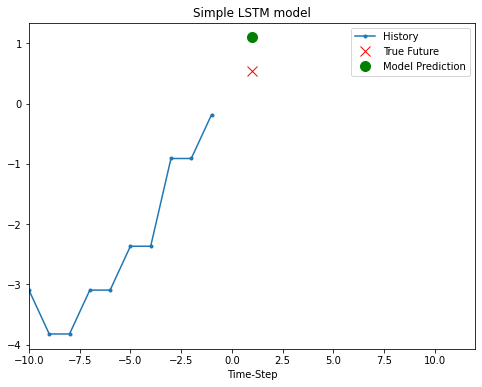

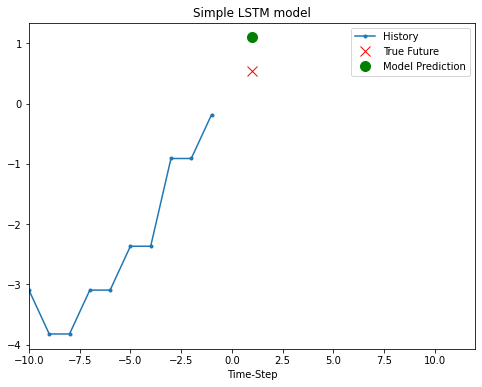

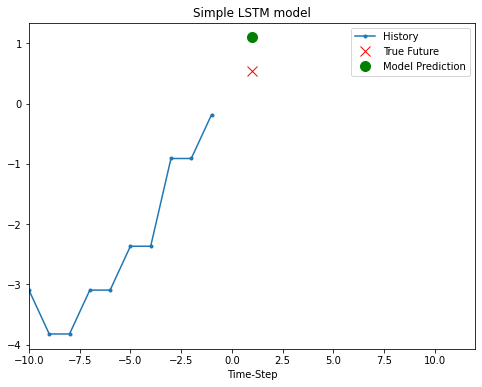

In [154]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 1, 'Simple LSTM model')
  plot.show()

Conclusion - it sucks

# Multivariate Time Series 
Chaos rune price prediction from history of runecrafting, magic and previous chaos rune prices

In [155]:
features_runes = ['Law_rune', 'Blood_rune']
features_skills =  []
features = pd.concat([rune_df[features_runes],xp_df[features_skills]],axis=1) 
features.head()

,Law_rune,Blood_rune
0,144,392
1,144,391
2,144,390
3,144,389
4,144,390


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

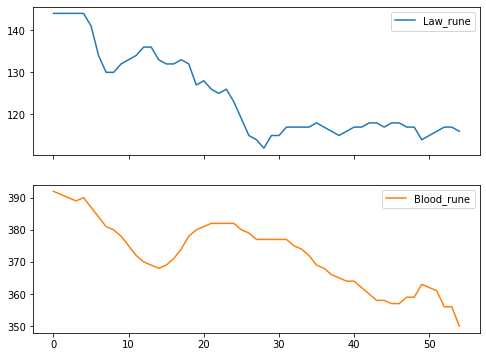

In [156]:
features.plot(subplots=True)

Normalize the dataset

In [157]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

### Single step model
Model will predict a single chaos rune price

In [158]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [159]:
past_history = 10
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [160]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (10, 2)


In [161]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [162]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Sample Prediction

In [163]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(4, 1)


In [164]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/15
500/500 [==============================] - 4s 4ms/step - loss: 0.1027 - val_loss: 1.1806
Epoch 2/15
500/500 [==============================] - 2s 3ms/step - loss: 0.0398 - val_loss: 1.1028
Epoch 3/15
500/500 [==============================] - 2s 3ms/step - loss: 0.0359 - val_loss: 1.2420
Epoch 4/15
500/500 [==============================] - 2s 3ms/step - loss: 0.0336 - val_loss: 1.4359
Epoch 5/15
500/500 [==============================] - 1s 3ms/step - loss: 0.0310 - val_loss: 1.9309
Epoch 6/15
500/500 [==============================] - 2s 3ms/step - loss: 0.0293 - val_loss: 2.2132
Epoch 7/15
500/500 [==============================] - 1s 3ms/step - loss: 0.0275 - val_loss: 2.3119
Epoch 8/15
500/500 [==============================] - 1s 3ms/step - loss: 0.0262 - val_loss: 2.3091
Epoch 9/15
500/500 [==============================] - 1s 3ms/step - loss: 0.0249 - val_loss: 2.3905
Epoch 10/15
500/500 [==============================] - 2s 3ms/step - loss: 0.0238 - val_loss: 2.5803

In [165]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

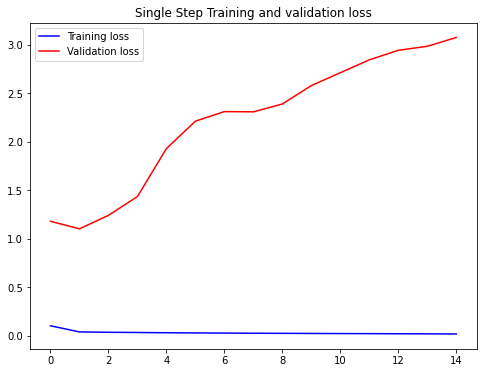

In [166]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

### Single Step Prediction
it's time to make some predictions

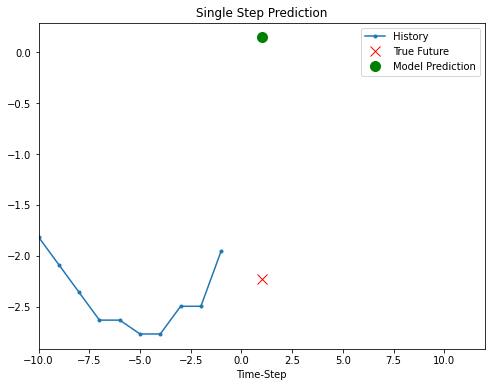

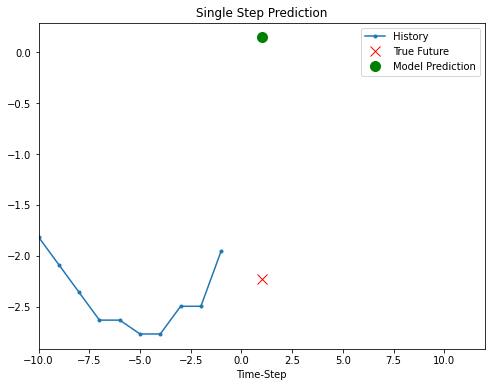

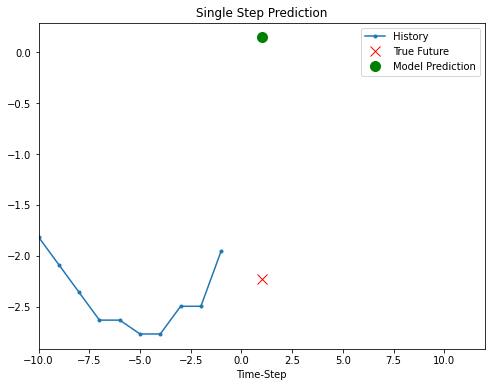

In [167]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

### Multi-Step Model

In [168]:
future_target = 5
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [169]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (10, 2)

 Target temperature to predict : (5,)


In [170]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [171]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

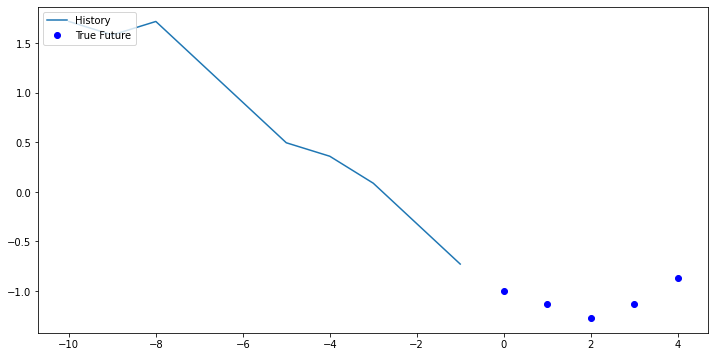

In [172]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Two LSTM layers with 72 predictions

In [173]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
# multi_step_model.add(tf.keras.layers.Dense(72))
multi_step_model.add(tf.keras.layers.Dense(future_target))


multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [174]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

In [175]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/15
490/500 [============================>.] - ETA: 0s - loss: 0.2584

ValueError: in user code:

    c:\users\rahel\pycharmprojects\osrsinvestor\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:1323 test_function  *
        return step_function(self, iterator)
    c:\users\rahel\pycharmprojects\osrsinvestor\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:1314 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\rahel\pycharmprojects\osrsinvestor\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\rahel\pycharmprojects\osrsinvestor\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\rahel\pycharmprojects\osrsinvestor\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\rahel\pycharmprojects\osrsinvestor\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:1307 run_step  **
        outputs = model.test_step(data)
    c:\users\rahel\pycharmprojects\osrsinvestor\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:1266 test_step
        y_pred = self(x, training=False)
    c:\users\rahel\pycharmprojects\osrsinvestor\venv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\users\rahel\pycharmprojects\osrsinvestor\venv\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:215 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_9 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1)


In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

### Multi Step Prediction

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])